# Neuron 2-projection on-off activation coverage (1) - MNIST CNN

Start by fixing the random seed to ensure reproducability. In all our examples, we use 42. 

In [1]:
import numpy.random
# Fix the number for repeatability (we have also stored the trained model)
numpy.random.seed(42)


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all required library, and set the device.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import h5py
import scipy.misc
import math
import matplotlib.pyplot as plt
from torch.autograd  import Variable
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.inception import inception_v3

from PIL import Image
from scipy.misc import imsave
import os


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Define hyper-parameters. The parameter "sizeOfNeuronsToMonitor" is the number of neurons we will monitor, which is the 2nd to last layer. 

In [4]:
# Hyper-parameters 
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001
sizeOfNeuronsToMonitor = 40

Then , prepare the training and test set. MNIST can be directly downloaded. Notice that we do not normalize the input data, but just rely on small learning rates. 

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



Define a utility function to display MNIST images. 

In [6]:
import util
    

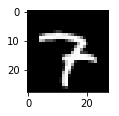

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

util.displayMNIST(images[0].numpy())


### Prepare the network 

To use run-time monitoring, apart from standard "forward()" function, we additionally define another function to return values of intermediate layers. 


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
 
        self.conv1 = nn.Conv2d(1, 40, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 20, 5)
        self.fc1 = nn.Linear(20 * 4 * 4, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, sizeOfNeuronsToMonitor)
        self.fc4 = nn.Linear(sizeOfNeuronsToMonitor, num_classes)
        
    def forward(self, x):
        # Original 28x28x1 -(conv)-> 24x24x40 -(pool)-> 12x12x40
        x = self.pool(F.relu(self.conv1(x)))
        # Original 12x12x40 -(conv)-> 8x8x20 -(pool)-> 4x4x20
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out 
  
    # Here we add another function, which does the same forward computation but also extracts intermediate layer results
    def forwardWithIntermediate(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        intermediateValues = x
        x = F.relu(x)
        out = self.fc4(x)
        return out, intermediateValues    
    
net = NeuralNet()
net.eval()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  



Load the model (if you have a pretrained one)

In [9]:
# Setup model to be attacked
# net = NeuralNet()
net.load_state_dict(torch.load('models/1_model_MNIST_CNN.ckpt'))

Train the model

In [10]:

furtherTrain = False

if furtherTrain: 

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))



### Compute accuracy on the test set

In [11]:
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
     

Accuracy of the network on the 10000 test images: 98.81 %


### Trigger 2-projection neuron on-off activation coverage computation


In [18]:
from nndependability.metrics import KProjection

k_Value = 3

metric = KProjection.Neuron_OnOff_KProjection_Metric(k_Value, sizeOfNeuronsToMonitor)

Exception: for k-projection coverage where k != 2, it is not supported

Trigger the function addInputs() to update the k-projection table based on all visited patterns for each batch. 

In [15]:
with torch.no_grad():

    total = 0
    i = 0
    for images, labels in train_loader:
        
        total = total + (len(labels))
        labels = labels.to(device)
        outputs, intermediateValues = net.forwardWithIntermediate(images)
        
        # Add the batch of neuron activation patterns to the k-projection table
        metric.addInputs(intermediateValues)
                
        if(i % 10) == 0:
            print('Current input size: '+str(total))
            metric.printMetricQuantity()
            print("\n")
        i = i+1
        
    print('Accuracy of the network on the all train images: {} %'.format(100 * correct / total))


Current input size: 64
2-projection neuron on-off activation coverage:2745/3120=0.8798076923076923


Current input size: 704
2-projection neuron on-off activation coverage:2841/3120=0.9105769230769231


Current input size: 1344
2-projection neuron on-off activation coverage:2849/3120=0.9131410256410256


Current input size: 1984
2-projection neuron on-off activation coverage:2860/3120=0.9166666666666666


Current input size: 2624
2-projection neuron on-off activation coverage:2866/3120=0.9185897435897435


Current input size: 3264
2-projection neuron on-off activation coverage:2867/3120=0.9189102564102564


Current input size: 3904
2-projection neuron on-off activation coverage:2871/3120=0.9201923076923076


Current input size: 4544
2-projection neuron on-off activation coverage:2871/3120=0.9201923076923076


Current input size: 5184
2-projection neuron on-off activation coverage:2873/3120=0.9208333333333333


Current input size: 5824
2-projection neuron on-off activation coverage:2873

KeyboardInterrupt: 

In [16]:
metric.printMetricQuantity()

2-projection neuron on-off activation coverage:2931/3120=0.9394230769230769
